# LOWESS

散布図に従う近似線を描くために開発された局所回帰。
**LOESS (locally estimated scatterplot smoothing)** や **LOWESS (locally weighted scatterplot smoothing)** と呼ばれる。

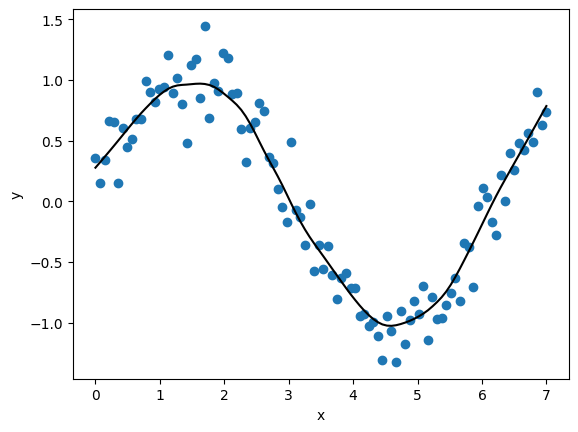

In [1]:
import numpy as np
np.random.seed(0)
x = np.linspace(0, 7, 100)
y = np.sin(x) + np.random.normal(0, 0.2, 100)

import statsmodels.api as sm
smoothed = sm.nonparametric.lowess(exog=x, endog=y, frac=0.2, it=3)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
ax.set(xlabel="x", ylabel="y")
fig.show()

## LOWESSのアルゴリズム

[Cleveland, W. S. (1979).](https://sites.oxy.edu/lengyel/m150/other/Robust%20Locally%20Weighted%20Regression%20and%20Smoothing%20Scatterplots_JASA1997_Cleveland.pdf) に記されたアルゴリズムは以下の通り。

$i$番目のサンプルの目的変数$y_i$を特徴量$x_i$とノンパラメトリックの平滑化関数$g(x_i)$で近似することを考える。

$$
y_i = g(x_i) + \epsilon_i
$$

ここで$\epsilon_i$は平均0で分散が一定の確率変数である。



### 1. 重みの計算と$r$個の最近傍サンプルの取得

$x_i$について、$j=1,\dots,n$にわたって$|x_i - x_j|$で距離を測り、$r$番目に近いサンプルとの距離を$h_i$とする。

重み関数$W(\cdot)$を用いて、$k=1,\dots,n$について

$$
w_k(x_i) = W(h_i^{-1}(x_k - x_i))
$$

を計算する

ここで重み関数$W(\cdot)$は以下の性質を満たすものとする

1. $|x| < 1$について $W(x) > 0$
2. $W(-x)=W(x)$
3. $W(x)$ は $x \geq 0$について 非増加関数
4. $|x| \geq 1$について$W(x)=0$

$h_i^{-1}(x_k - x_i)$は分子の$x_k - x_i$の絶対値が分母の$h_i$より大きければ$|h_i^{-1}(x_k - x_i)| \geq 1$になるので重みが0になる。つまり、サンプルとして回帰に使用されなくなる。
なので重み関数は近傍の$r$個のサンプルを取り出しつつ、$r$個のサンプルにも距離に応じた重みをかける操作となる。

$W$の例として tricube functionが考えられる

$$
W(x) =
\begin{cases}
(1-|x|^3)^3 & \text { for } \quad|x|<1 \\
0 \quad & \text { for } \quad|x| \geqslant 1
\end{cases}
$$

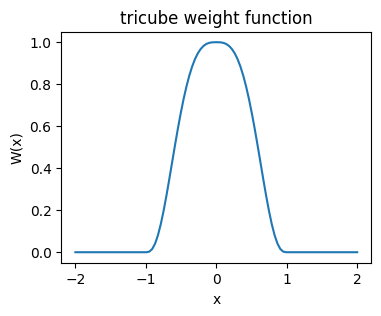

In [102]:
def tricube(x: float) -> float:
    if np.abs(x) >= 1:
        return 0
    return (1 - np.abs(x)**3 )**3

x = np.linspace(-2, 2, 100)
w = [tricube(x_i) for x_i in x]

# 別のやり方
# w = (1 - np.abs(x)**3)**3
# w[np.abs(x) >= 1] = 0
fig, ax = plt.subplots(figsize=[4,3])
ax.plot(x, w)
ax.set(title="tricube weight function", xlabel="x", ylabel="W(x)")
fig.show()

### 2. 多項式回帰のフィッティング

非線形回帰として$d$次の多項式回帰を行う

$$
\min_{\beta_0,\dots,\beta_d} ~ \sum_{k=1}^n w_k\left(x_i\right)\left(y_k-\beta_0-\beta_1 x_k-\ldots-\beta_d x_k^d\right)^2
$$


$$
\hat{y}_i=\sum_{j=0}^d \hat{\beta}_j\left(x_i\right) x_i^j
$$

### 3. ロバスト性重み$\delta$の計算

続いて、外れ値の影響を除外するための重みを計算する。
bisquare weight function $B(x)$を以下のように定義する

$$
B(x) =
\begin{cases}
(1 - x^2)^2 & \text { for } \quad|x| < 1 \\
0 \quad & \text { for } \quad|x| \geqslant 1
\end{cases}
$$

残差$e_i = y_i - \hat{y}_i$の絶対値$|e_i|$の中央値を$s$とする。ロバスト性重み（robustness weights）を

$$
\delta_k = B(e_k / 6s)
$$

と定義する。$B(x)$もtricube functionと似た形状であり、残差の絶対値の中央値の6倍（$6s$）以上の残差$e_k/6s \geq 1$を持つ外れ値は重み$\delta_k$がゼロになり、推定に含まれなくなる。

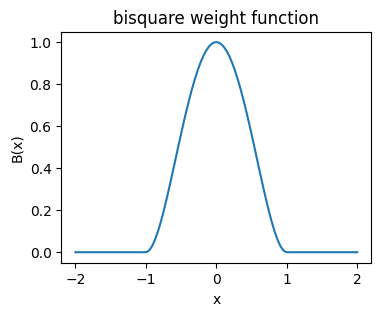

In [3]:
def bisquare(x: float) -> float:
    if np.abs(x) >= 1:
        return 0
    return (1 - x**2 )**2

x = np.linspace(-2, 2, 100)
b = [bisquare(x_i) for x_i in x]
fig, ax = plt.subplots(figsize=[4,3])
ax.plot(x, b)
ax.set(title="bisquare weight function", xlabel="x", ylabel="B(x)")
fig.show()

### 4. $\delta$で重み付け回帰を行う

また$d$次多項式回帰を行い、新たな推定値$\hat{y}_i$を得る。このとき、重みは$\delta_k w_k (x_i)$を使う。


### 5. 繰り返す

3.と4.のステップを$t$回繰り返す。


## 実装イメージ

In [164]:
# サンプルデータ
import numpy as np
n = 100
np.random.seed(0)
x = np.linspace(0, 7, n)
y = np.sin(x) + np.random.normal(0, 0.2, n)

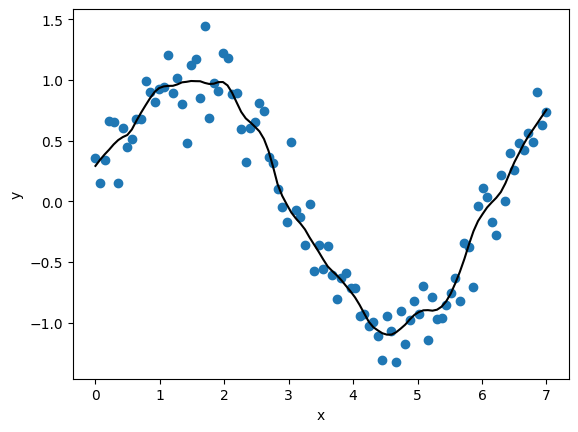

In [177]:
r = 10  # 使用する近傍のサンプル数
d = 2  # 多項式回帰の次数
t = 3  # iteration

def tricube(x: np.array) -> np.array:
    w = (1 - np.abs(x)**3)**3
    w[np.abs(x) >= 1] = 0
    return w

def bisquare(x: np.array) -> np.array:
    w = (1 - np.abs(x)**2)**2
    w[np.abs(x) >= 1] = 0
    return w

# d次多項式を作るための特徴量生成
X = np.vstack([x**j for j in range(d)]).T

n, m = X.shape
delta = np.ones_like(x)
y_pred = np.zeros_like(x)
for _ in range(t):
    for i in range(n):
        # 重みの計算
        dist = x - x[i]
        idx = np.argsort(np.abs(dist))[:r]
        h_i = np.abs(dist[idx]).max() # r番目に近いdiff
        w = tricube(dist / h_i)
        W = np.diag(delta * w)
    
        # WLS
        beta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y
        y_pred[i] = X[i,:] @ beta
    
    e = y - y_pred
    s = np.median(np.abs(e))
    delta = bisquare(e / (6 * s))

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, y_pred, c="k")
ax.set(xlabel="x", ylabel="y")
fig.show()

## 最近のLOWESSアルゴリズム

Wikipediaには、重み関数がtricubeではなくGaussianを使うものが紹介されている

2つのデータ点の特徴量ベクトル$x, x' \in \mathbb{R}^m$（$m$は特徴量の次元数）について、

$$
w(x, x', \alpha)=\exp \left(-\frac{\|x-x'\|^2}{2 \alpha^2}\right)
$$



## 参考

- [Local regression - Wikipedia](https://en.wikipedia.org/wiki/Local_regression)
- Cleveland, W. S. (1979). [Robust locally weighted regression and smoothing scatterplots.](https://sites.oxy.edu/lengyel/m150/other/Robust%20Locally%20Weighted%20Regression%20and%20Smoothing%20Scatterplots_JASA1997_Cleveland.pdf) Journal of the American statistical association, 74(368), 829-836.

